# Simulate the data

In [41]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import dirichlet, multinomial
from scipy.sparse import lil_matrix
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

np.random.seed(37)

# number of topics
K = 10
# number of words
N = 100
# number of documents
M = 1000

# priors on K topics
a = np.array([0.1, 0.2, 0.3, 0.4, 0.025, 0.015, 0.37, 0.88, 0.03, 0.08])
# priors on N words
b = np.full((1, N), 0.001, dtype=float)[0]

# distribution of words in topic k
psi = np.array([dirichlet.rvs(b)[0] for _ in range(K)])

# distribution of topics in document d
theta = np.array([dirichlet.rvs(a)[0] for _ in range(M)])

# simulate the documents
docs = []
for i in range(M):
    d = {}
    for j in range(N):
        z_ij = multinomial.rvs(1, theta[i])
        topic = np.argmax(z_ij)
        
        w_ij = multinomial.rvs(1, psi[topic])
        word = np.argmax(w_ij)
        
        if word not in d:
            d[word] = 0
        d[word] = d[word] + 1
    docs.append(d)

# make a nice matrix
X = lil_matrix((M, N), dtype=np.int16)
for i, d in enumerate(docs):
    counts = sorted(list(d.items()), key=lambda tup: tup[0])
    for tup in counts:
        X[i, tup[0]] = tup[1]
        
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

# Look at the distribution

In [42]:
means = X.mean(axis=0)
means = [(i, means[0, i]) for i in range(means.shape[1]) if means[0, i] > 0.0]

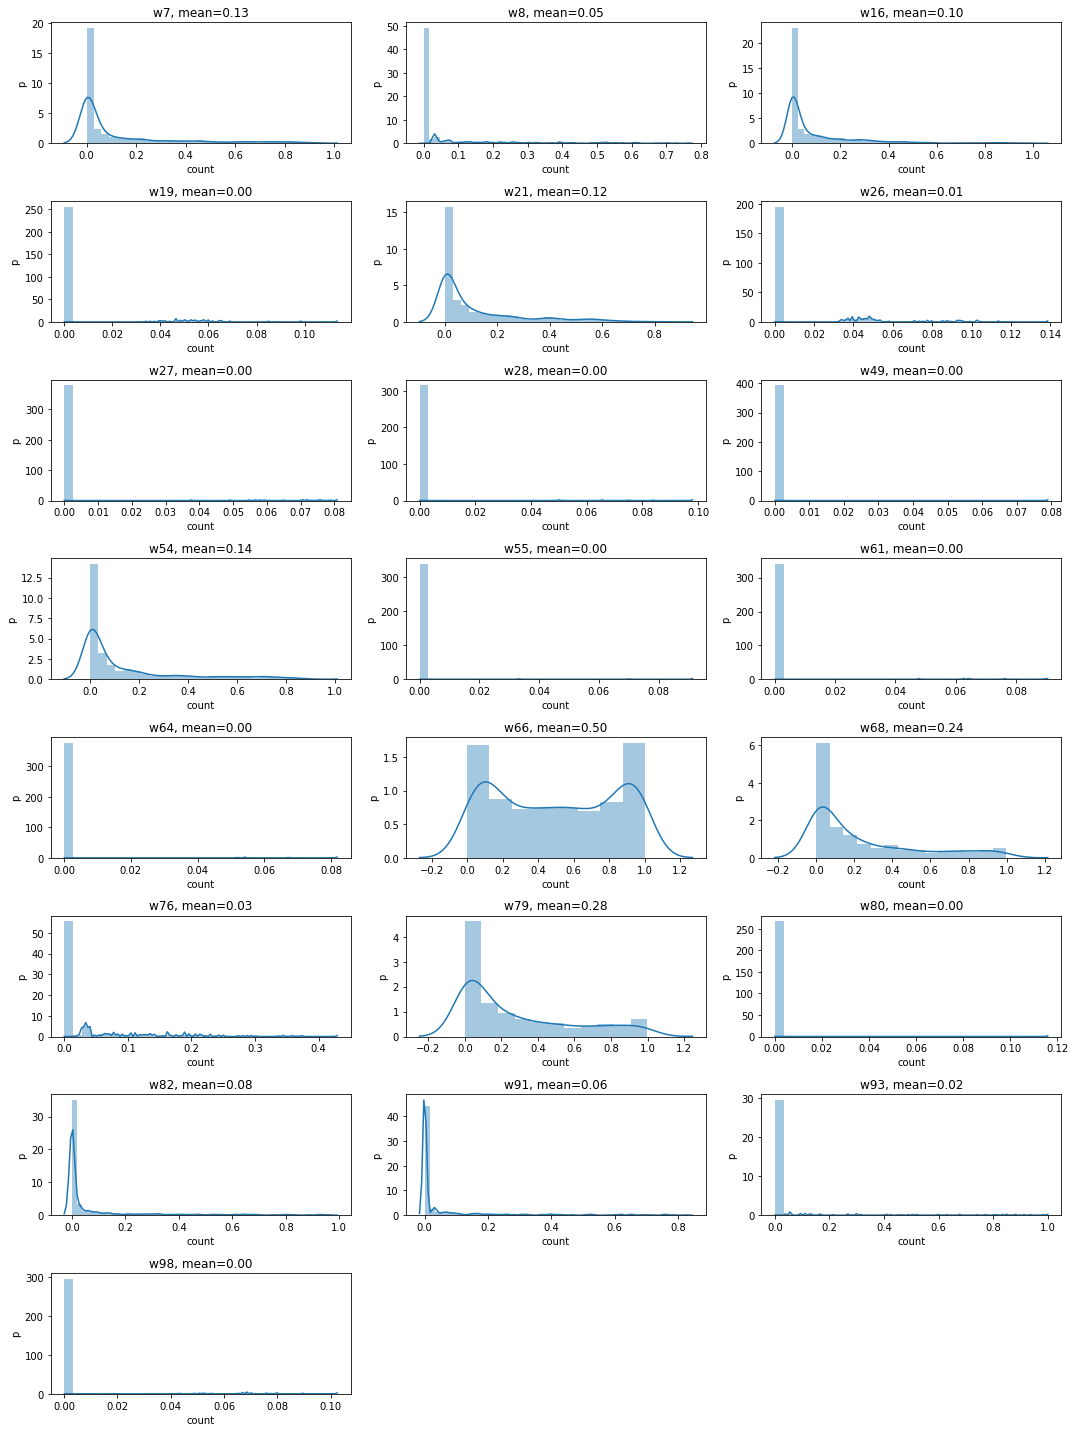

In [43]:
import math

n = len(means)
n_cols = 3
n_rows = math.ceil(n / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 20))
ax = np.ravel(ax)

for i in range(len(ax)):
    if i < len(means):
        idx = means[i][0]
        mu = means[i][1]
        data = X[:,idx].toarray().reshape(1, -1)[0]
        sns.distplot(data, ax=ax[i])
        ax[i].set_title('w{}, mean={:.2f}'.format(idx, mu))
        ax[i].set_ylabel('p')
        ax[i].set_xlabel('count')
    else:
        ax[i].axis('off')

plt.tight_layout()

# Look at the pairwise correlations

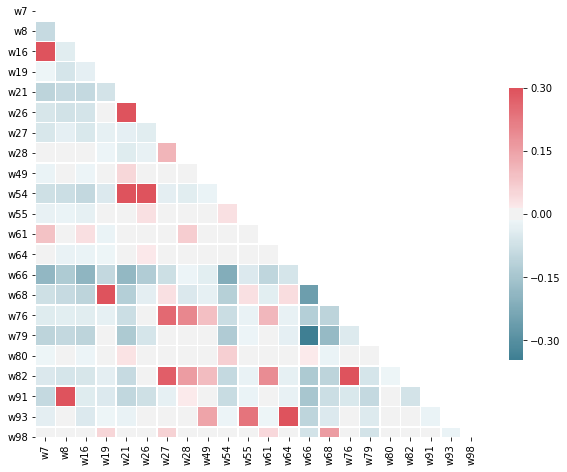

In [44]:
indices = sorted([tup[0] for tup in means])
df = pd.DataFrame(X[:, indices].toarray(), columns=['w{}'.format(i) for i in indices])
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Gaussian mixture models

In [65]:
from scipy.sparse.linalg import svds

U, S, V = svds(X, k=20)

In [74]:
from sklearn.mixture import GaussianMixture

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=200, random_state=37)
    gmm.fit(X)
    aic = gmm.aic(X)
    bic = gmm.bic(X)
    print('{}: aic={}, bic={}'.format(k, aic, bic))
    return aic, bic, k, gmm

gmm_scores = [get_gmm_labels(U, k) for k in range(2, 26)]

2: aic=-91377.49259322303, bic=-89115.01740961226
3: aic=-115401.48064695929, bic=-112005.31399390365
4: aic=-140093.3393354111, bic=-135563.48121291058
5: aic=-140323.78987370565, bic=-134660.24028176026
6: aic=-141875.76088709006, bic=-135078.5198256998
7: aic=-148775.5523375182, bic=-140844.61980668307
8: aic=-144864.3404425131, bic=-135799.71644223307
9: aic=-145063.49226211192, bic=-134865.17679238704
10: aic=-150715.19037699106, bic=-139383.1834378213
11: aic=-152996.5234889575, bic=-140530.82508034288
12: aic=-155759.24880410952, bic=-142159.85892605002
13: aic=-154738.5265758916, bic=-140005.44522838722
14: aic=-155298.35704192484, bic=-139431.5842249756
15: aic=-155273.8626619101, bic=-138273.39837551597
16: aic=-158229.5442474468, bic=-140095.3884916078
17: aic=-158801.92826365976, bic=-139534.0810383759
18: aic=-158146.93107164965, bic=-137745.3923769209
19: aic=-157399.88209837984, bic=-135864.65193420622
20: aic=-158964.20247723098, bic=-136295.2808436125
21: aic=-156443.2

In [82]:
gmm = gmm_scores[14][3]

Text(0.5, 1.0, 'AIC vs k')

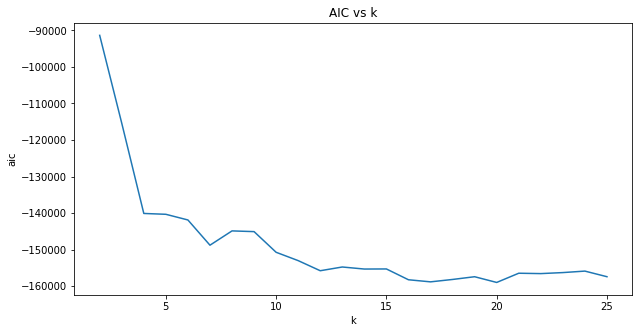

In [83]:
_x = [s[2] for s in gmm_scores]
_y = [s[0] for s in gmm_scores]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(_x, _y, color='tab:blue')
ax.set_xlabel('k')
ax.set_ylabel('aic')
ax.set_title('AIC vs k')

# k-means clustering

In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_kmc(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    print('{}: score={}'.format(k, score))
    return score, k, model

kmc_scores = [get_kmc(X, k) for k in range(2, 26)]

2: score=0.22136552497539078
3: score=0.2606191325546754
4: score=0.2985364557161296
5: score=0.32764563696557253
6: score=0.34711980577628615
7: score=0.36212754809252495
8: score=0.3693035922796191
9: score=0.3118628444238988
10: score=0.32070416934016466
11: score=0.3056882384904699
12: score=0.28297903762485543
13: score=0.28462816984240946
14: score=0.2747613933318139
15: score=0.2787478862359055
16: score=0.27452088253304896
17: score=0.2548015324435892
18: score=0.25961952207924777
19: score=0.25650479556223627
20: score=0.251690199350559
21: score=0.2566617758778615
22: score=0.25866268014756943
23: score=0.24607465357359543
24: score=0.24936289940720038
25: score=0.2579644562276278


Text(0.5, 1.0, 'Silhouette vs k')

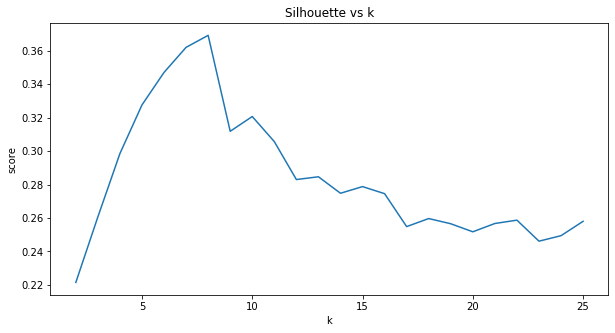

In [87]:
_x = [s[1] for s in kmc_scores]
_y = [s[0] for s in kmc_scores]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(_x, _y, color='tab:blue')
ax.set_xlabel('k')
ax.set_ylabel('score')
ax.set_title('Silhouette vs k')

# Text analysis

In [104]:
def dict_to_text(d):
    def convert(p):
        w = 'w{} '.format(p[0])
        s = w * p[1]
        s = s.strip()
        return s
    
    pairs = list(d.items())
    return ' '.join([convert(p) for p in pairs])
        
T = [dict_to_text(docs[i]).split(' ') for i in range(len(docs))]

In [108]:
from gensim import corpora

dictionary = corpora.Dictionary(T)
print(dictionary)
print(dictionary.token2id)

Dictionary(22 unique tokens: ['w16', 'w21', 'w54', 'w66', 'w68']...)
{'w16': 0, 'w21': 1, 'w54': 2, 'w66': 3, 'w68': 4, 'w7': 5, 'w79': 6, 'w8': 7, 'w91': 8, 'w76': 9, 'w82': 10, 'w93': 11, 'w26': 12, 'w19': 13, 'w64': 14, 'w98': 15, 'w27': 16, 'w55': 17, 'w61': 18, 'w80': 19, 'w28': 20, 'w49': 21}


In [111]:
corpus = [dictionary.doc2bow(text) for text in T]

In [114]:
from gensim.models import TfidfModel

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [128]:
from gensim.models import LsiModel, LdaModel

lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=15)
corpus_lsi = lsi[corpus_tfidf]

lda = LdaModel(corpus_tfidf, id2word=dictionary, num_topics=15)
corpus_lda = lda[corpus_tfidf]

In [129]:
lsi.print_topics(5)

[(0,
  '0.507*"w79" + 0.462*"w68" + 0.365*"w54" + 0.356*"w7" + 0.311*"w21" + 0.255*"w16" + 0.214*"w82" + 0.143*"w66" + 0.141*"w91" + 0.119*"w8"'),
 (1,
  '-0.691*"w7" + -0.458*"w16" + 0.375*"w54" + 0.323*"w21" + 0.244*"w79" + -0.068*"w82" + 0.039*"w26" + 0.030*"w66" + -0.025*"w76" + 0.024*"w91"'),
 (2,
  '-0.654*"w79" + 0.529*"w54" + 0.423*"w21" + -0.193*"w82" + 0.191*"w7" + 0.121*"w16" + -0.096*"w91" + -0.083*"w8" + -0.065*"w76" + 0.054*"w26"'),
 (3,
  '-0.868*"w68" + 0.276*"w79" + 0.261*"w82" + 0.186*"w54" + 0.152*"w7" + 0.141*"w21" + 0.099*"w16" + 0.088*"w76" + 0.051*"w8" + 0.045*"w91"'),
 (4,
  '-0.718*"w82" + 0.417*"w79" + -0.348*"w91" + -0.298*"w8" + -0.236*"w76" + 0.168*"w7" + -0.098*"w68" + 0.078*"w16" + 0.016*"w21" + 0.013*"w54"')]

In [130]:
lda.print_topics(5)

[(11,
  '0.217*"w82" + 0.186*"w79" + 0.145*"w16" + 0.080*"w7" + 0.068*"w76" + 0.050*"w68" + 0.048*"w91" + 0.047*"w8" + 0.045*"w54" + 0.045*"w66"'),
 (9,
  '0.186*"w82" + 0.135*"w7" + 0.128*"w79" + 0.108*"w91" + 0.089*"w8" + 0.083*"w68" + 0.063*"w76" + 0.061*"w16" + 0.039*"w54" + 0.038*"w21"'),
 (0,
  '0.211*"w68" + 0.170*"w79" + 0.107*"w7" + 0.097*"w54" + 0.085*"w91" + 0.076*"w21" + 0.062*"w8" + 0.055*"w16" + 0.034*"w66" + 0.032*"w82"'),
 (13,
  '0.199*"w82" + 0.153*"w68" + 0.118*"w79" + 0.114*"w54" + 0.089*"w7" + 0.084*"w21" + 0.065*"w76" + 0.049*"w16" + 0.036*"w66" + 0.025*"w93"'),
 (2,
  '0.218*"w68" + 0.160*"w54" + 0.154*"w21" + 0.116*"w79" + 0.059*"w66" + 0.059*"w7" + 0.052*"w16" + 0.047*"w82" + 0.036*"w93" + 0.026*"w26"')]

In [131]:
for doc in corpus_lsi:
    print(doc)
    break

[(0, 0.6319407911602479), (1, -0.6876861913998217), (2, 0.21090712063659023), (3, -0.24885738690436904), (4, 0.11431371784540093), (5, -0.006792044158069128), (6, -0.039738807163860856), (7, 0.018971768308814856), (8, -0.07373476993501683), (9, 0.001169030431217074), (10, 0.001111533200453943), (11, -0.005194386672537434), (12, 0.002358487378803362), (13, 0.027761847717178257), (14, 0.005293831317634169)]


In [133]:
for doc in corpus_lda:
    print(doc)
    break

[(0, 0.024129), (1, 0.024129016), (2, 0.024129005), (3, 0.024129108), (4, 0.024128975), (5, 0.02412898), (6, 0.024128992), (7, 0.024128964), (8, 0.02412901), (9, 0.024128968), (10, 0.02412896), (11, 0.024128968), (12, 0.02412901), (13, 0.024128987), (14, 0.662194)]
